## <b><u> Time series Forecasting for Favorita Store Sales </b></u>
   - `In this project we will be building a regression model and understand hw to use it`
   - `We will also examine the correlation coeffcient,multiple regression  and logisti regression methods`
   - `using logistic regression we will be able to estimate the probability of the business success over give period of time`
   - `finally; develop a time series Analysis`



### <u><b><i> Description </u></b></i>
` As a data scientist, I will be looking at a favorita  grocery stores data  and predict a little over time based on th sales performance previously... </ `
 - The Favorita Grocery Sales Forecasting competition is a time series forecasting competition hosted by the Favorita Food Markets Association. The goal is to predict the sales of various products sold in multiple locations over time. The dataset provided includes sales data, promotions, and other relevant features.
 - `The dataset includes;;;;;;;;;;;;`
- train.csv: includes store_number, family, onpromotion and target sales
- test.csv: same as train.csv(predict sales data)
- transaction.csv: date,store_number,transation 
- sample_submission.csv: 
- stores.csv: store metabase including city, state,type and cluster
 - oils.csv: daily oil price
 - holidays_events.csv: Holidays events
 ## Questions
 1. Is the train dataset complete (has all the required dates)?
 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)
 3. Compare the sales for each month across the years and determine which month of which year had the highest sales. 
 4. Did the earthquake impact sales?
 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
 6. Are sales affected by promotions, oil prices and holidays
 7. What analysis can we get from the date and its extractable features?
 8. Which product family and stores did the promotions affect.
 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.
 ### <u><b><i> HYPOTHESIS</u></b></i>
Null hypothesis;`The type of holiday does not have any significance on the increase of sales`
Alternative hypothesis; `The type of holiday do have significant on the increase of sales`

In [66]:
#installing pyodbc & python-dotenv
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sn
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource
import mplcursors
from bokeh.io import output_notebook
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import RandomizedSearchCV,train_test_split
import xgboost as xgb




In [2]:
#load environment variable from .env file
environment_variable =dotenv_values('.env')
#we get the credentails  fro th env file
database=environment_variable.get('DATABASE')
server=environment_variable.get('SERVER')
username=environment_variable.get('USERNAME')
password=environment_variable.get('PASSWORD')
# Establish connection
connection_string= f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [3]:
#We need to use the connection method that is the pyodbc library
connection=pyodbc.connect(connection_string)

In [4]:
#SQL query to get the dat 
query_oil="SELECT* FROM dbo.oil"
query_stores="SELECT* FROM dbo.stores"
query_holidays_events="SELECT* FROM dbo.holidays_events"
df_oil=pd.read_sql(query_oil,connection)
df_stores=pd.read_sql(query_stores,connection)
df_holidays_events=pd.read_sql(query_holidays_events,connection)
# Close the connection





In [5]:
#load csv data set
df_submission=pd.read_csv("sample_submission (1).csv")
df_test=pd.read_csv("test (1).csv")
df_transaction=pd.read_csv("transactions.csv")



In [6]:
##sql EDA
#summary statisitcs for th column
oil_sum=df_oil.describe().T
event_sum=df_holidays_events.describe().T
store_sum=df_stores.describe().T
##result
print("holiday summary:")
display(event_sum)
print('*'*40)
print("Store Summary:")
display(store_sum)
print('$'*40)
print("oil summary:")
display(oil_sum)
print('-'*40)




holiday summary:


,count,unique,top,freq
date,350,312,2014-06-25,4
type,350,6,Holiday,221
locale,350,3,National,174
locale_name,350,24,Ecuador,174
description,350,103,Carnaval,10
transferred,350,2,False,338


****************************************
Store Summary:


,count,mean,std,min,25%,50%,75%,max
store_nbr,54.0,27.500000,15.732133,1.0,14.25,27.5,40.75,54.0
cluster,54.0,8.481481,4.693395,1.0,4.00,8.5,13.00,17.0


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
oil summary:


,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1175.0,67.714366,25.630476,26.190001,46.405001,53.189999,95.66,110.620003


----------------------------------------


In [7]:
#missing values
print("event missing values:")
events_missing=df_holidays_events.isnull().sum()
display(events_missing)
print('*'*40)
print("oil missing values:")
oil_missing=df_oil.isnull().sum()
display(oil_missing)
print('*'*40)
print("store missing values:")
store_missing=df_stores.isnull().sum()
display(store_missing)
print('*'*40)

event missing values:


date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

****************************************
oil missing values:


date           0
dcoilwtico    43
dtype: int64

****************************************
store missing values:


store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

****************************************


In [8]:
print("holiday shape:")
print('*'*40)
holiday_shape=df_holidays_events.shape
print("rows:",holiday_shape[0])
print("column",holiday_shape[1])
#oilshape
print("oil shape:")
print('*'*40)
oil_shape=df_oil.shape
print("rows:",oil_shape[0])
print("column",oil_shape[1])

#store shape
print("store shape:")
print("<>"*40)
store_shape=df_stores.shape
print("rows:",store_shape[0])
print("column:",store_shape[1])



holiday shape:
****************************************
rows: 350
column 6
oil shape:
****************************************
rows: 1218
column 2
store shape:
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
rows: 54
column: 5


#### <i><u> SCV EDA </u></i>

In [9]:
## SCV SUMMARY STATTISITCS 
transaction_summary= df_transaction.describe().T 
#Test summary
test_summary=df_test.describe().T

#Submission summary
submission_summary=df_submission.describe().T

#print summary
print("transaction summary:")
display(transaction_summary)
print("*"*50)

print("submission summary:")
display(submission_summary)
print("*"*50)

print("test summary:")
display(test_summary)



transaction summary:


,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


**************************************************
submission summary:


,count,mean,std,min,25%,50%,75%,max
id,28512.0,3015143.5,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
sales,28512.0,0.0,0.000000,0.0,0.00,0.0,0.00,0.0


**************************************************
test summary:


,count,mean,std,min,25%,50%,75%,max
id,28512.0,3.015144e+06,8230.849774,3000888.0,3008015.75,3015143.5,3022271.25,3029399.0
store_nbr,28512.0,2.750000e+01,15.586057,1.0,14.00,27.5,41.00,54.0
onpromotion,28512.0,6.965383e+00,20.683952,0.0,0.00,0.0,6.00,646.0


In [10]:
#shape check
print(f"transaction rows:{df_transaction.shape}")
print(f"submission shape:{df_submission.shape}")
print(f"test shape:{df_test.shape}")

transaction rows:(83488, 3)
submission shape:(28512, 2)
test shape:(28512, 5)


In [11]:
#Missing values
print(f"transcaction missing values:{df_transaction.isna().sum()}")
print(f"submission missing data{df_submission.isna().sum()}")
print(f"test missing values:{df_test.isna().sum()}")



transcaction missing values:date            0
store_nbr       0
transactions    0
dtype: int64
submission missing dataid       0
sales    0
dtype: int64
test missing values:id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


#### <i><u> handling missing values</u></i>

` for this case we have value mising on the dcoil on the data file and we will use back fill method because;`

- because the data is a time sries  and missing values is due to temporary gaps like holidays or weekends 
- we will assume the secondly recorded values remains valid

In [12]:
#find missing values in the oil data file
df_oil['dcoilwtico']=df_oil['dcoilwtico'].fillna(method='backfill')
df_oil.isnull().sum()
#print(f"filling missing data:{df_oil['dcoilwtico'].fillna( method='backfill')}")

date          0
dcoilwtico    0
dtype: int64

In [13]:
df_train=pd.read_csv("train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [14]:
##change train data date type from object to dat type
#check date completeness
print (f"min_date;{df_train['date'].min()},max date:{df_train['date'].max()}")
print("   "*60)
expected_date= pd.date_range(start=df_train['date'].min(), end=df_train['date'].max())
mising_date=expected_date[~expected_date.isin(df_train['date'])]

if len(mising_date)==0:
    print("complete")
else:
    print(f"missing date:{mising_date}")



min_date;2013-01-01,max date:2017-08-15
                                                                                                                                                                                    
missing date:DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


Train data has chrismas holiday as the  missing date

In [15]:
# covert dates from object to datetim
df_train['date']=pd.to_datetime(df_train['date'])

#complete the missind dateby creating an index of missing dates
missing_dates=pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

#add the missing dates to the dataframe
missing_data=pd.DataFrame({'date':missing_dates})
#concat
df_train=pd.concat([df_train,missing_data],ignore_index=True)

#sort the dataframe by date

df_train.sort_values(by='date', inplace=True)



In [16]:
#set the date type in te csv file as  date type
df_test=pd.read_csv("test (1).csv",parse_dates=['date'])
df_train=pd.read_csv("train.csv",parse_dates=['date'])
df_transaction=pd.read_csv("transactions.csv",parse_dates=['date'])
df_submission=pd.read_csv("sample_submission (1).csv")

### <b><u> Checking for stationarity</u></b>
    - checking for stationarity in a time series column[date] is very necessary for understanding the statistical propertes of the dataset and dtermine in the appropriate model technidue to use
A time series is statinary if the statisitical properties [mean,variance add covariance] remain consant over time
- ARIMA and SARIMA models assume stationarity 
non-stationary data  can lead to invalid results

In [17]:
# Define the function to check stationarity
def check_stationarity(df, column, title=''):
    """
    Checks stationarity of a numeric time series using the Augmented Dickey-Fuller test.
    """
    print(f"\nStationarity check for: {title}")
    
    # Validate if the column exists in the DataFrame
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in the DataFrame.")
        return
    
    # Drop missing values in the selected column
    data = df[column].dropna()
    
    # Perform the ADF test
    result = adfuller(data)
    
    # Print the test results
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    
    # Check the p-value to decide stationarity
    if result[1] <= 0.05:
        print("Reject null hypothesis (data is stationary).")
    else:
        print("Fail to reject null hypothesis (data is non-stationary).")

# Apply the stationarity check on the numeric column (e.g., 'transaction_data')
check_stationarity(df_transaction, column='transactions', title='Transaction Data')


Stationarity check for: Transaction Data
ADF Statistic: -16.5742
p-value: 0.0000
Critical Values: {'1%': -3.4304283896674406, '5%': -2.8615746469290144, '10%': -2.566788441361157}
Reject null hypothesis (data is stationary).


### Fit ARIMA Model
ARIMA REQUIRES 3 PARAMETERS:
- p(AR):Autoregressive terms
- d(I):Differencing order
- q(MA): Moving Average

Here we will use first order differencing to make the data stationary


In [18]:
## differencing the dta

auto_model=auto_arima(
    df_transaction['transactions'],
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=74.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1370457.889, Time=1.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1362169.673, Time=1.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1357240.650, Time=5.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1370455.889, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=44.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1354840.083, Time=6.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1354005.374, Time=16.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1353905.362, Time=24.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1354817.520, Time=18.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1353565.832, Time=49.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=136.69 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1347870.688, Time=84.62 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=106.37 sec
 ARIMA(3,1,4

In [19]:
p, d, q =auto_model.order

# Fit ARIMA model
model=ARIMA(df_transaction['transactions'],order=(p, d, q))
arima_result =model.fit()


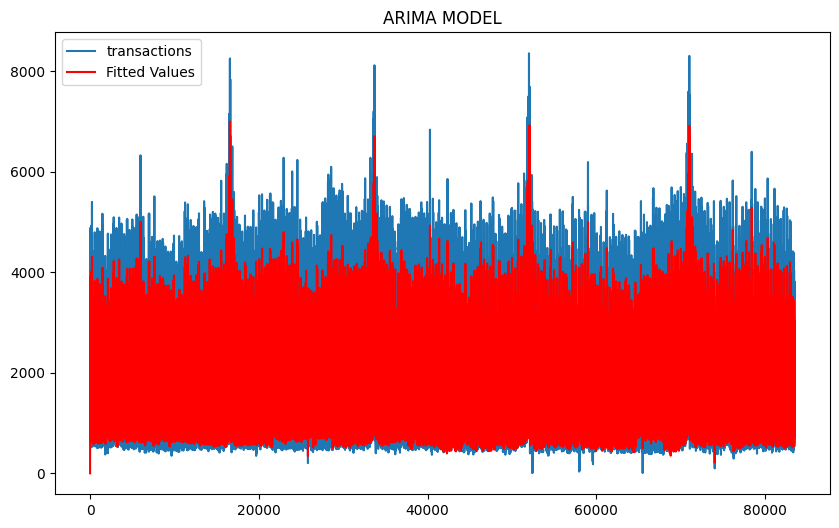

In [20]:
plt.figure(figsize=(10,6))
plt.plot(df_transaction['transactions'],label='transactions')
plt.plot(arima_result.fittedvalues,label='Fitted Values',color='red')
plt.legend()
plt.title('ARIMA MODEL')
plt.show()

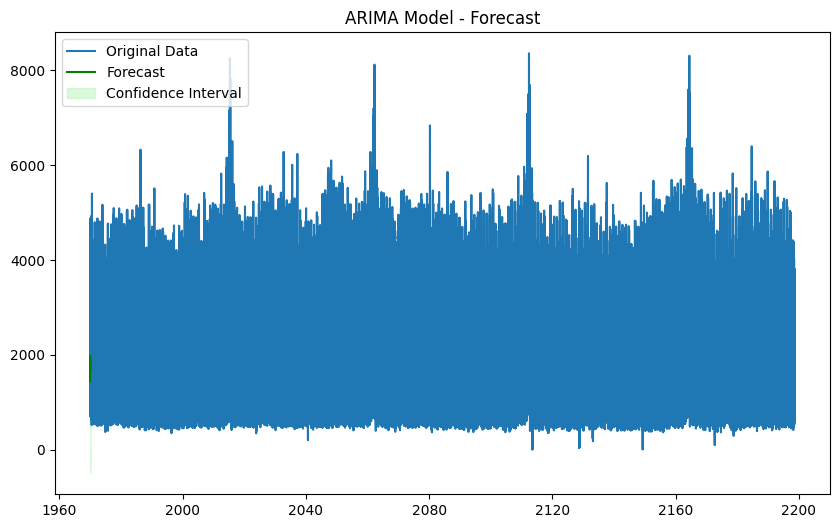

In [21]:
# Forecast future values (e.g., next 10 periods)
forecast_steps = 10
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(
    start=df_transaction.index[-1],
    periods=forecast_steps + 1,  # Include the starting point
    freq='D'  # Adjust frequency as needed
)[1:]

# Get forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot original data and forecasts
plt.figure(figsize=(10, 6))
plt.plot(df_transaction['transactions'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(
    forecast_index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='lightgreen', alpha=0.3, label='Confidence Interval'
)
plt.legend()
plt.title('ARIMA Model - Forecast')
plt.show()

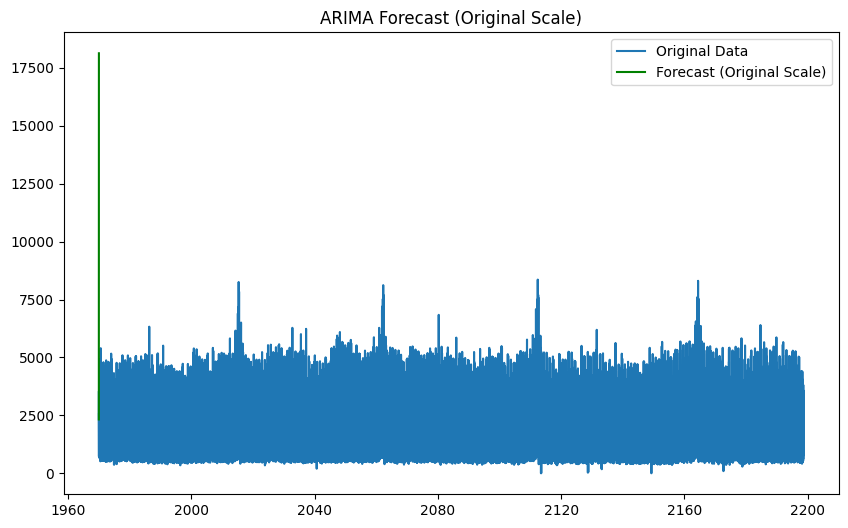

In [22]:
# Add the last observed value to forecasted differences
forecast_original_scale = forecast_values.cumsum() + df_transaction['transactions'].iloc[-1]

# Plot the forecasts in the original scale
plt.figure(figsize=(10, 6))
plt.plot(df_transaction['transactions'], label='Original Data')
plt.plot(forecast_index, forecast_original_scale, label='Forecast (Original Scale)', color='green')
plt.legend()
plt.title('ARIMA Forecast (Original Scale)')
plt.show()

## <b><i> CRUDE OIL PRICES CHANGES OVER TIME</i></b>

In [18]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [19]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


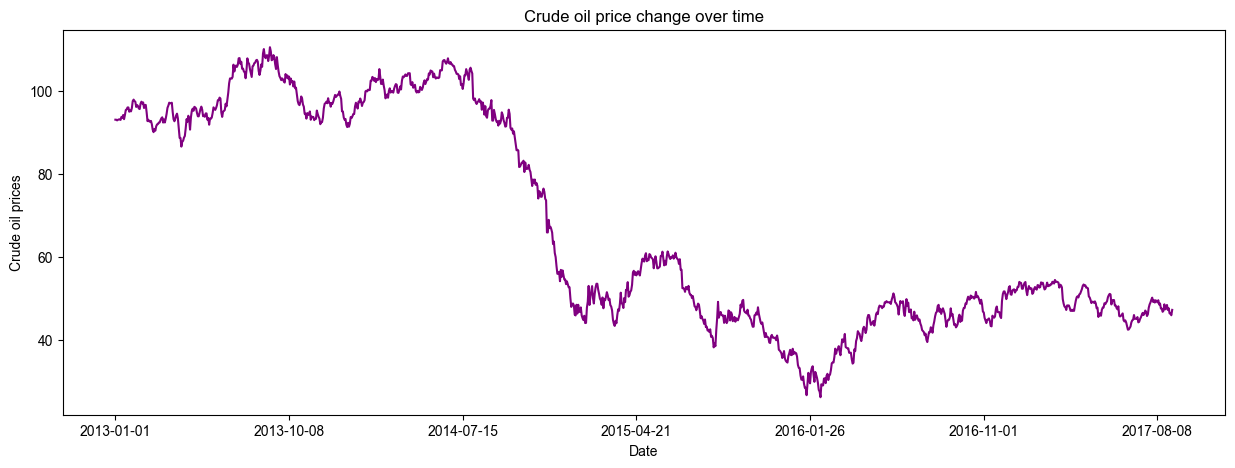

In [20]:
df_oil.set_index("date")
df_oil.plot(x="date",y="dcoilwtico",color="purple",legend=False,figsize=(15,5))
plt.title("Crude oil price change over time")
plt.xlabel("Date")
plt.ylabel("Crude oil prices")
plt.style.use('seaborn-v0_8-whitegrid')
# Add hover functionality
mplcursors.cursor(hover=True)

# Show plot
plt.show()



## FEATURING ENGINEERING
prepare the data for the ML; The process will involve extracting and transforming the ML Model

In [21]:
df_holidays_events['date']=pd.to_datetime(df_holidays_events['date'])
df_holidays_events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [22]:
df_oil['date']=pd.to_datetime(df_oil['date'])
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [23]:
df_holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [24]:
#merge the file
df_timeseries=df_train.merge(df_stores,on='store_nbr',how='inner')
df_timeseries=df_timeseries.merge(df_holidays_events,on='date',how='inner')
df_timeseries=df_timeseries.merge(df_oil,on='date',how='inner')
df_timeseries=df_timeseries.merge(df_transaction,on=['date','store_nbr'],how='inner')


>STEP 1: FEATURE TRANSFORMATION 
- 1.Scaling
- 2.Encoding categorical variables
- 3.Log Transormation
>STEP 2:FEATURE SCALING
- 1. remove redundant feature
- 2. statistical test
- 3. feature importance 
>STEP 3: FEATURE CREATION

In [25]:
df_timeseries.info(object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  type_y        322047 non-null  object        
 11  locale        322047 non-null  object        
 12  locale_name   322047 non-null  object        
 13  description   322047 non-null  object        
 14  transferred   322047 non-null  bool          
 15  dcoilwtico    322

In [48]:
#Scaling Columns in the  Serial data
numerical_features=['sales','dcoilwtico','transactions']
Categorical_features=['family', 'city', 'state', 'type_x', 'type_y', 'locale', 'locale_name', 'description']
#scale the numeric 
scaler=StandardScaler()
scaled_features=scaler.fit_transform(df_timeseries[numerical_features])


In [27]:
#scaling categorical features one-hot encoding
onehot_encoder=OneHotEncoder(sparse=False)
encoded_features=onehot_encoder.fit_transform(df_timeseries[Categorical_features])

#scaling numeric feature
scale_df=pd.DataFrame(scaled_features,columns=numerical_features)

# Create a dataframe for the encoded categorical features
encoded_df=pd.DataFrame(encoded_features,columns=onehot_encoder.get_feature_names_out(Categorical_features))

#concatenate the features for the scaled and encoded features
transformed_df=pd.concat([df_timeseries['date'],scale_df,encoded_df],axis=1)
transformed_df.head(5)

,date,sales,dcoilwtico,transactions,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,description_Terremoto Manabi+30,description_Terremoto Manabi+4,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
0,2013-01-01,-0.325920,1.186995,-0.917916,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,-0.325920,1.186995,-0.917916,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,-0.324316,1.186995,-0.917916,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,0.323701,1.186995,-0.917916,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,-0.325920,1.186995,-0.917916,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train and Test Data Splitting

 in this case we will use sequential splitting commonly used for TimeSeries datasets.
 this is becos the data set is correlated 

In [31]:
#define date split
split_date="2017-01-01"
split_date=pd.Timestamp(split_date)
train_data=transformed_df[transformed_df['date']<split_date]
df_test=transformed_df[transformed_df['date']>=split_date]
#propotional data split
split_index=int(len(transformed_df)*0.8)
# separate the features 
X_train=train_data.drop(['date','sales'],axis=1)
Y_train=train_data['sales']
X_test=df_test.drop(['date','sales'],axis=1)
Y_test=df_test['sales']
#reset the index 

X_train=X_train.reset_index(drop=True)
Y_train=Y_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)
Y_test=Y_test.reset_index(drop=True)
# <b><i> MODELLING</i></b>
print(f'legth of the  x_train: {len(X_train),len(Y_train),len(X_test),len(Y_test)}')

legth of the  x_train: (284889, 284889, 37158, 37158)


for categorical features - we use <b> Catboost Regressor</b>. we need minimal hyperparameters tuning.
step1: training CatBoost Regressor
2. Making  Predictions
3. Evaluate perfomance
4. Handle categorical features
5. Hyperparameter tuning
6. feature importance tuning




In [43]:
# trainign CatBoost Regressor
catboost_model= CatBoostRegressor(iterations=1500,learning_rate=0.1,depth=10,loss_function='RMSE',verbose=100,random_state=42)
# train the model
catboost_model.fit(X_train, Y_train, eval_set=(X_test,Y_test), early_stopping_rounds=50)

0:	learn: 0.9197258	test: 1.0091046	best: 1.0091046 (0)	total: 56.8ms	remaining: 1m 25s
100:	learn: 0.3975174	test: 0.4015000	best: 0.3999511 (88)	total: 7.77s	remaining: 1m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3999510869
bestIteration = 88

Shrink model to first 89 iterations.


In [44]:
#2. Making predictions
y_pred= catboost_model.predict(X_test)
#3 evaluate perfomance

mse=mean_squared_error(Y_test,y_pred)
rmse= mse**0.5
print(f"RMSE:{rmse}")

RMSE:0.3999510880167486


In [42]:
#Random SearchCV for a  more efficient Alternative
param_dist= {'depth':[4,6,8,10], 'learning_rate':[0.01,0.05,0.1],'iterations':[500,1000,1500]}
random_search= RandomizedSearchCV(estimator=catboost_model,param_distributions=param_dist,n_iter=10,scoring='neg_mean_absolute_error',cv=3,verbose=2,random_state=42)
random_search.fit(X_train,Y_train)
print('Best parameter:',random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 1.0251479	total: 67.6ms	remaining: 1m 41s
100:	learn: 0.4391868	total: 6.75s	remaining: 1m 33s
200:	learn: 0.3684643	total: 12.7s	remaining: 1m 21s
300:	learn: 0.3238976	total: 18.8s	remaining: 1m 14s
400:	learn: 0.2915003	total: 25.2s	remaining: 1m 9s
500:	learn: 0.2684523	total: 31.3s	remaining: 1m 2s
600:	learn: 0.2499890	total: 37.6s	remaining: 56.2s
700:	learn: 0.2353590	total: 43.6s	remaining: 49.7s
800:	learn: 0.2235775	total: 49.4s	remaining: 43.1s
900:	learn: 0.2143575	total: 54.9s	remaining: 36.5s
1000:	learn: 0.2059458	total: 1m	remaining: 30.1s
1100:	learn: 0.1983809	total: 1m 5s	remaining: 23.9s
1200:	learn: 0.1919395	total: 1m 11s	remaining: 17.9s
1300:	learn: 0.1859732	total: 1m 17s	remaining: 11.8s
1400:	learn: 0.1810190	total: 1m 22s	remaining: 5.84s
1499:	learn: 0.1769373	total: 1m 28s	remaining: 0us
[CV] END .......depth=10, iterations=1500, learning_rate=0.1; total time= 1.5min
0:	learn: 0.925613

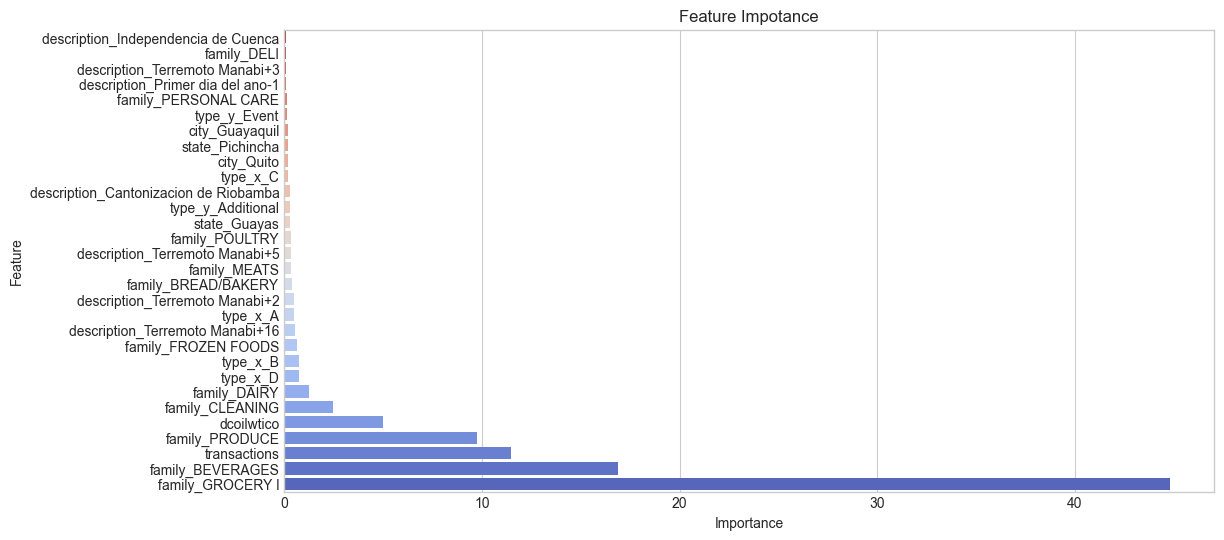

In [64]:
feature_importance=catboost_model.get_feature_importance()
feature_importance_df=pd.DataFrame({"Feature":X_train.columns,
                                    "Importance":feature_importance})
#Sort Features by Importance
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)
N=30
top_features=feature_importance_df.head(N)
plt.figure(figsize=(12,6))
sn.barplot(y='Feature',x='Importance',data=top_features,color='skyblue',palette="coolwarm")
plt.xlabel("Importance", fontsize=10)
plt.ylabel("Feature",fontsize=10)
plt.title("Feature Impotance")
plt.gca().invert_yaxis() #for better visualization
plt.show()



In [65]:
catboost_model.save_model('catboost_model.cbm')

<b><i><u>XGBoost Regressor</u></b></i> : is known for efficiency, accuracy and scalability used ons structured data;
1. handles large datasets effcientlu ad prevent overfitting
2. handles missing values automatically and work well with sparse data making it suitable for categorical data


In [74]:
xgb_regressor=xgb.XGBRegressor(
    n_estimators=1000,    # number of boosting rounds
    learning_rate=0.05,   #step size shinkage
    max_depth=9,
    subsample=1.0,        #fraction of sample used for training
    colsample_bytree=1.0,   # fraction of features used per tree
    objective='reg:squarederror',
    nthread=-1,
    random_state=42,
)
xgb_regressor.fit(X_train,Y_train,eval_set=[(X_test,Y_test)],early_stopping_rounds=50,verbose=100)

[0]	validation_0-rmse:1.04875
[100]	validation_0-rmse:0.41111
[200]	validation_0-rmse:0.40889
[227]	validation_0-rmse:0.40957


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [76]:
#make prediction to evaluate the Model
#predict on the test data
y_predict=xgb_regressor.predict(X_test)
#Evaluate perfomance
mae=mean_absolute_error(Y_test,y_predict)
mse=mean_squared_error(Y_test,y_predict)
rmse=np.sqrt(mse)
r2=r2_score(Y_test,y_predict)
print(f"MAE:{mae:4F}")
print(f"MSE:{mse:4f}")
print(f"RMSE:{rmse:4F}")
print(f"R2 Score:{r2:4F}")


MAE:0.109202
MSE:0.166914
RMSE:0.408551
R2 Score:0.858796


In [72]:
#Hypertuning of the Xgboost
param_grid={
    'n_estimators':[100,500,1000],
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[3,6,9],
    'subsample':[0.7,0.8,1.0],
    'colsample_bytree':[0.7,0.8,1.0]
}

In [73]:


#set up randommized search cv
random_search_cv=RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=param_grid,n_iter=10,scoring='neg_mean_absolute_error',cv=3,verbose=2,random_state=42)

random_search_cv.fit(X_train,Y_train)
print('best parameters:',random_search_cv.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7; total time= 1.0min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=  39.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=  42.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7; total time=  44.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=1.0; total time=  46.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=1.0; total time=  43.1s
[CV] 

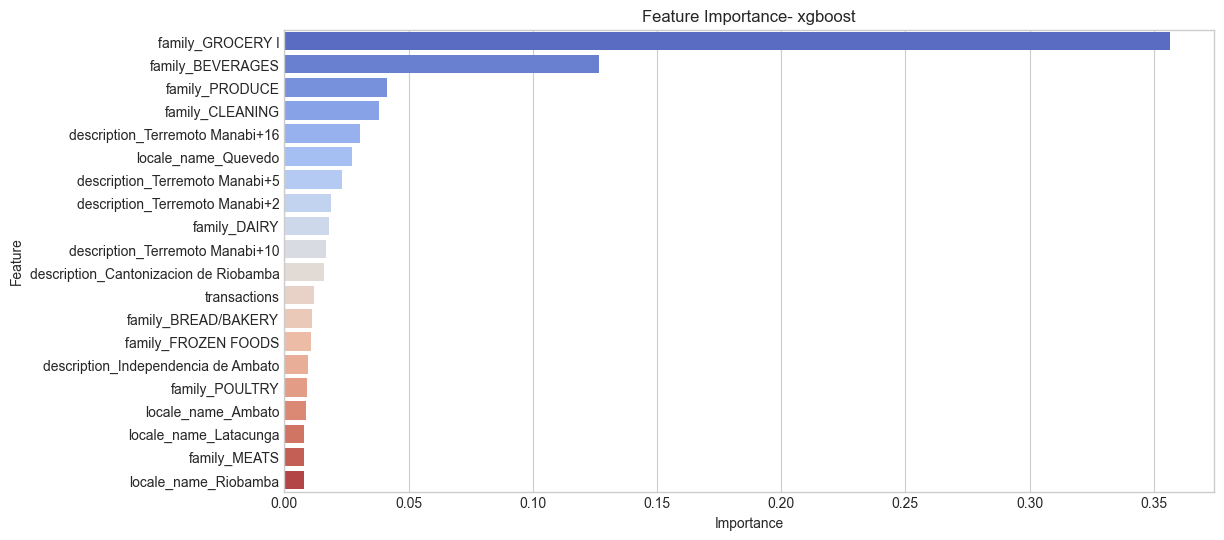

In [77]:
#step 5: Feature importance Analysis
Feature_importance_2=xgb_regressor.feature_importances_
#covert to df
impotance_df=pd.DataFrame({
    "Feature":X_train.columns,
    "Importance":Feature_importance_2
}).sort_values(by="Importance", ascending=False)

#plt the features
N=20
plt.figure(figsize=(12,6))
sn.barplot(x="Importance", y="Feature", data=impotance_df.head(N), color="skyblue", palette="coolwarm")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance- xgboost")
plt.show()

In [78]:
xgb_regressor.save_model('xgb_regressor.xgb')